###Librerías

In [172]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import mstats

###pricing_tools

In [173]:

def graficar_barras_linea(df, x_col, y_col_barras, y_col_linea, titulo="Gráfico combinado de barras y línea"):
    """
    Función para graficar un diagrama de barras con una línea superpuesta.

    Parámetros:
    - df: DataFrame de Pandas.
    - x_col: Nombre de la columna para el eje x (categorías).
    - y_col_barras: Nombre de la columna para el eje y de las barras (pesos).
    - y_col_linea: Nombre de la columna para el eje y de la línea (variable de respuesta).
    - titulo: Título del gráfico (opcional).
    """

    # Crear el gráfico
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Graficar las barras
    ax1.bar(df[x_col], df[y_col_barras], color='skyblue', label=y_col_barras, alpha=0.7)

    # Etiquetas para el eje de las barras
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col_barras, color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')

    # Crear un segundo eje Y para la línea
    ax2 = ax1.twinx()  # Comparte el mismo eje X

    # Graficar la línea
    ax2.plot(df[x_col], df[y_col_linea], color='orange', marker='o', label=y_col_linea)

    # Etiquetas para el eje de la línea
    ax2.set_ylabel(y_col_linea, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Título
    plt.title(titulo)

    # Rotar etiquetas del eje X si es necesario
    plt.xticks(rotation=90)

    # Asegurar que no se solapen los gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

def generar_formato_exposicion_homogenea(df, columna_interes, columna_exposicion, num_beans):
    """
    Genera un formato de beans con exposición homogénea basados en la exposición de otra columna y devuelve la columna
    de interés con el formato aplicado.

    :param df: DataFrame que contiene los datos.
    :param columna_interes: Nombre de la columna de interés que se quiere agrupar en bins.
    :param columna_exposicion: Nombre de la columna que contiene la exposición o peso.
    :param distribucion: Tipo de distribución ('normal', 'uniforme', etc.) para ajustar los beans (parámetro no usado en esta versión).
    :param num_beans: Número de beans o grupos a crear.
    :return: Serie con la columna de interés formateada en beans de exposición constante.
    """

    # Ordenar el DataFrame por la columna de interés para crear beans adecuados
    df = df.sort_values(by=columna_interes).reset_index(drop=True)

    # Calcular la exposición total y la exposición por cada bean
    exposicion_total = df[columna_exposicion].sum()
    exposicion_por_bean = exposicion_total / num_beans

    # Variable para rastrear la exposición acumulada y asignar beans
    exposicion_acumulada = 0
    limites_beans = []
    current_bean = 1
    limite_actual = df[columna_interes].iloc[0]  # Inicia en el valor mínimo

    # Recorrer el DataFrame fila por fila para crear los bins basados en exposición
    for i, fila in df.iterrows():
        exposicion_acumulada += fila[columna_exposicion]

        # Si alcanzamos la exposición deseada para este bin, guardar el límite superior
        if exposicion_acumulada >= exposicion_por_bean:
            limite_actual = fila[columna_interes]
            limites_beans.append(limite_actual)
            exposicion_acumulada = 0
            current_bean += 1
            if current_bean > num_beans:
                break  # No más beans después del número establecido

    # Si el número de beans es menor al solicitado, añadimos el máximo valor como último límite
    if len(limites_beans) < num_beans:
        limites_beans.append(df[columna_interes].max())

    # Usar pd.cut para aplicar los límites de los beans
    df['Columna_formateada'] = pd.cut(df[columna_interes], bins=[-np.inf] + limites_beans, duplicates='drop')

    return df['Columna_formateada']

###Leer diccionario de variables

In [174]:
dict_path=r'/content/data_dict.xlsx'
dict = pd.read_excel(dict_path)
dict.head()

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.0,0,1.0,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.0,0,1.0,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.0,0,1.0,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.0,0,1.0,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.0,0,1.0,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA


###Leemos el dataframe

In [175]:
import dask.dataframe as dd
df = dd.read_parquet('/content/Data')
df_sample = df.head(100000)

In [176]:
df_sample.head()

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,...,zona_inundable_centroids,zonas_agri,zonas_de_extraccion_minera,zonas_en_construccion,zonas_fore,zonas_hume,zonas_industriales_o_comerciales,zonas_portuarias,zonas_quemadas,zonas_verdes_urbanas
0,1033.0,552.0,31.0,NaN,31.0,99.0,4.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
1,1033.0,552.0,30.0,NaN,30.0,99.0,3.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
2,1033.0,552.0,33.0,NaN,33.0,99.0,6.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
3,1033.0,552.0,34.0,NaN,34.0,99.0,7.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
4,1033.0,552.0,36.0,NaN,36.0,99.0,6.0,1961.0,1961.0,0.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN


In [177]:
num_filas = df_sample.shape[0]
num_filas

100000

###Definir las variables de respuesta y peso

In [178]:
#Definimos las variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

###Filtrar pólizas que tienen exposición

In [179]:
df_sample=df_sample[df_sample[peso]>0]

In [180]:
df_sample['resp']=df_sample[var_resp]/df_sample[peso]

###Graficar histograma

In [181]:
def graficar_histograma(df, columna, bins=10, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia"):
    """
    Grafica un histograma de una variable específica de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna que se desea graficar (str).
    - bins: Número de bins en el histograma (opcional, por defecto 10).
    - titulo: Título del gráfico (opcional).
    - xlabel: Etiqueta para el eje X (opcional).
    - ylabel: Etiqueta para el eje Y (opcional).
    """
    # Comprobamos si la columna existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return

    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(df[columna].dropna(), bins=bins, color="skyblue", edgecolor="black")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Estudio de la composición de cartera por años

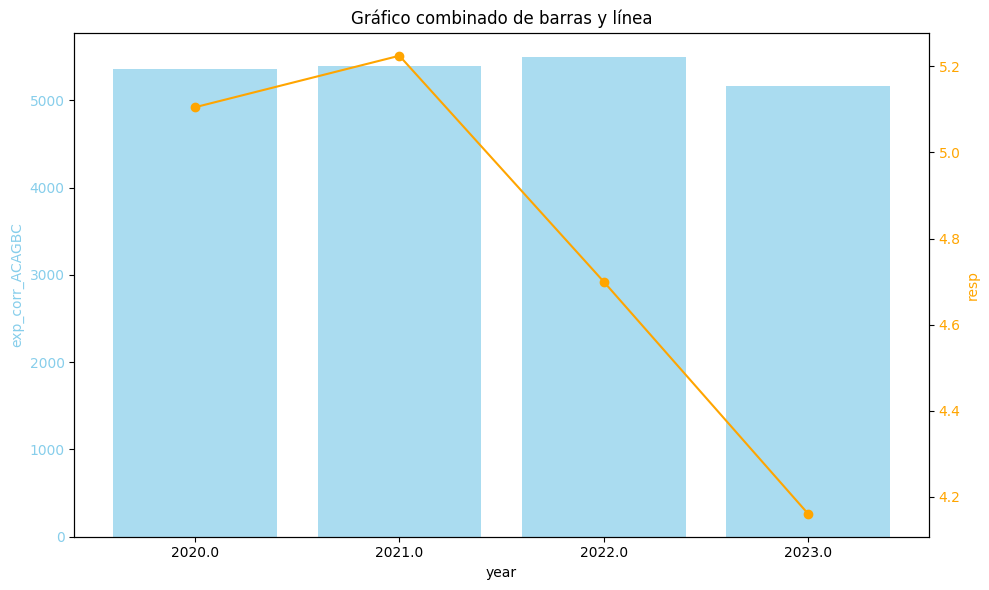

In [182]:
#Estudiar la variable respuesta por año
df_sample[ano]=df_sample[ano].astype(str)
df_resumido = df_sample.groupby(ano).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,ano,peso,'resp')

###Análisis de variables

####Altitud

In [183]:
#Detección de valores NaN
df_sample['Altitud'].isnull().sum()

np.int64(34)

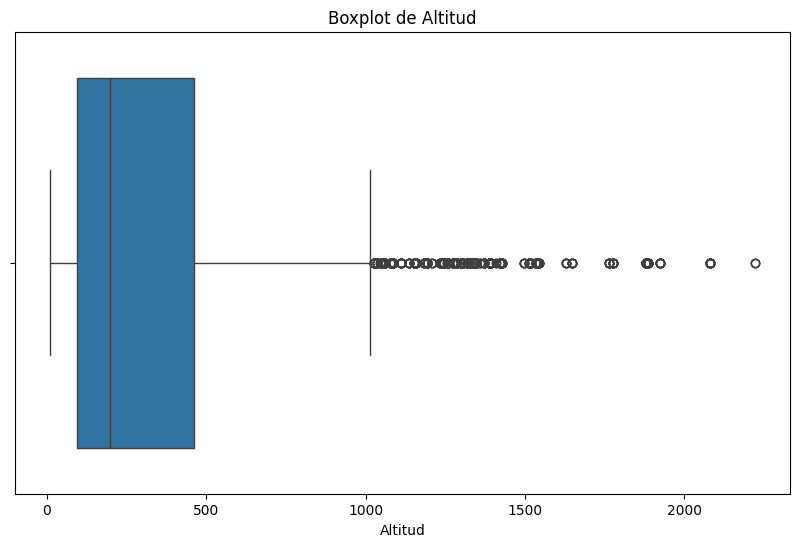

In [184]:
# Crear un boxplot para visualizar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Altitud'])
plt.title('Boxplot de Altitud')
plt.show()

In [185]:
# Aplicar winsorización
df_sample['Altitud_win'] = mstats.winsorize(df_sample['Altitud'], limits=[0.01, 0.01])
print(df_sample[['Altitud', 'Altitud_win']].head())

   Altitud  Altitud_win
0    552.0        552.0
1    552.0        552.0
2    552.0        552.0
3    552.0        552.0
8    552.0        552.0


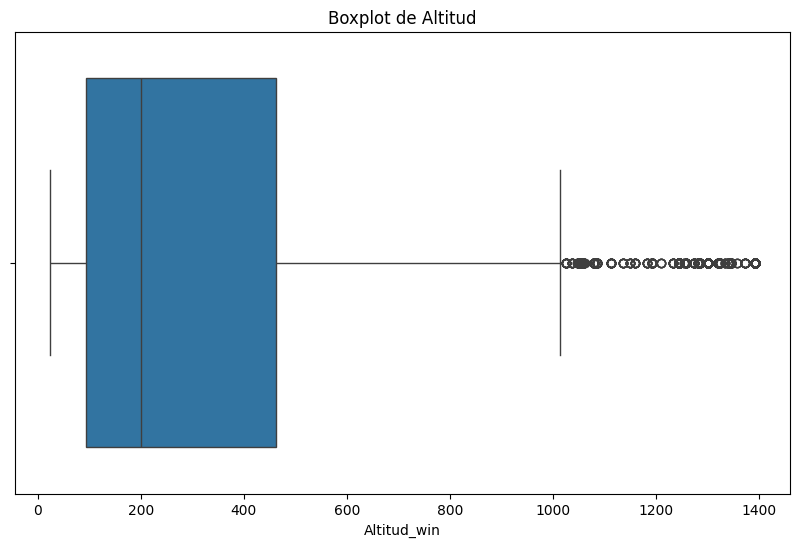

In [186]:
#Comprobar cambios
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Altitud_win'])
plt.title('Boxplot de Altitud')
plt.show()

In [187]:
# Agrupar altitud en rangos
df_sample['altitud_bin'] = pd.qcut(df_sample['Altitud_win'], q=10)  # puedes ajustar q
df_altitud = df_sample.groupby('altitud_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

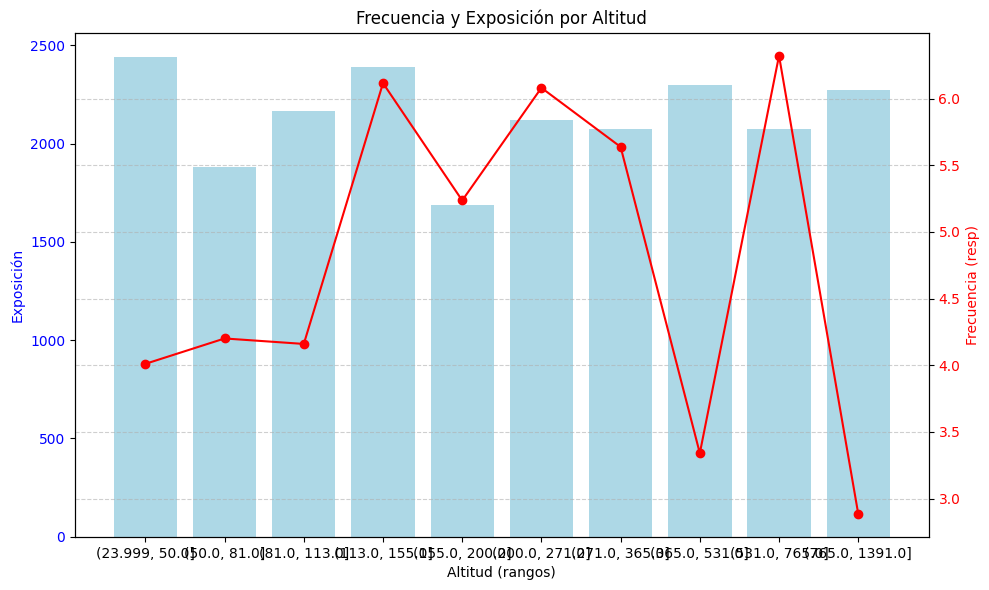

In [188]:

fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras: exposición
ax1.bar(df_altitud['altitud_bin'].astype(str), df_altitud['exp_corr_ACAGBC'], color='lightblue')
ax1.set_xlabel('Altitud (rangos)')
ax1.set_ylabel('Exposición', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Gráfico de línea: frecuencia promedio (resp)
ax2 = ax1.twinx()
ax2.plot(df_altitud['altitud_bin'].astype(str), df_altitud['resp'], color='red', marker='o')
ax2.set_ylabel('Frecuencia (resp)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Frecuencia y Exposición por Altitud')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Antiguedad vivienda

In [189]:
min_value = df['ANTIGUEDAD_VIVIENDA'].min().compute()
max_value = df['ANTIGUEDAD_VIVIENDA'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: 0.0
Valor máximo: 124.0


In [190]:
df_sample['ANTIGUEDAD_VIVIENDA'].isnull().sum()

np.int64(0)

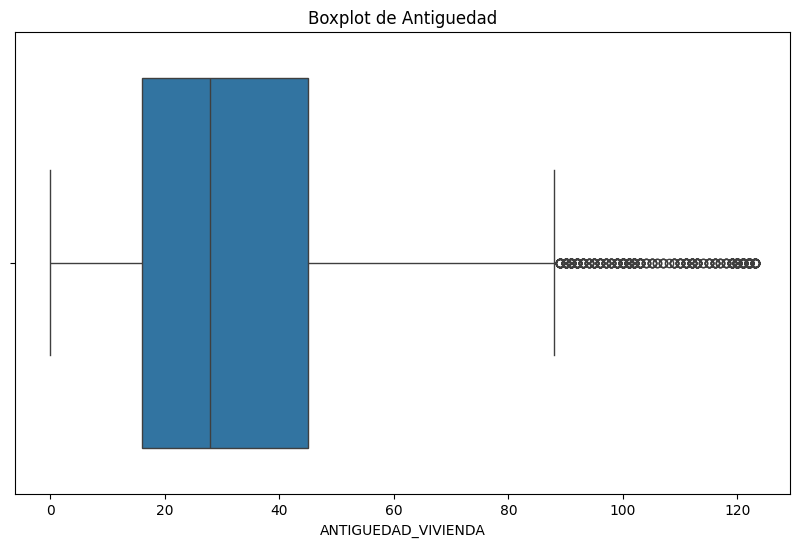

In [191]:
# Crear un boxplot para visualizar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['ANTIGUEDAD_VIVIENDA'])
plt.title('Boxplot de Antiguedad')
plt.show()

In [192]:
# Aplicar winsorización
df_sample['Antiguedad_win'] = mstats.winsorize(df_sample['ANTIGUEDAD_VIVIENDA'], limits=[0.01, 0.01])
print(df_sample[['ANTIGUEDAD_VIVIENDA', 'Antiguedad_win']].head())

   ANTIGUEDAD_VIVIENDA  Antiguedad_win
0                 31.0            31.0
1                 30.0            30.0
2                 33.0            33.0
3                 34.0            34.0
8                 38.0            38.0


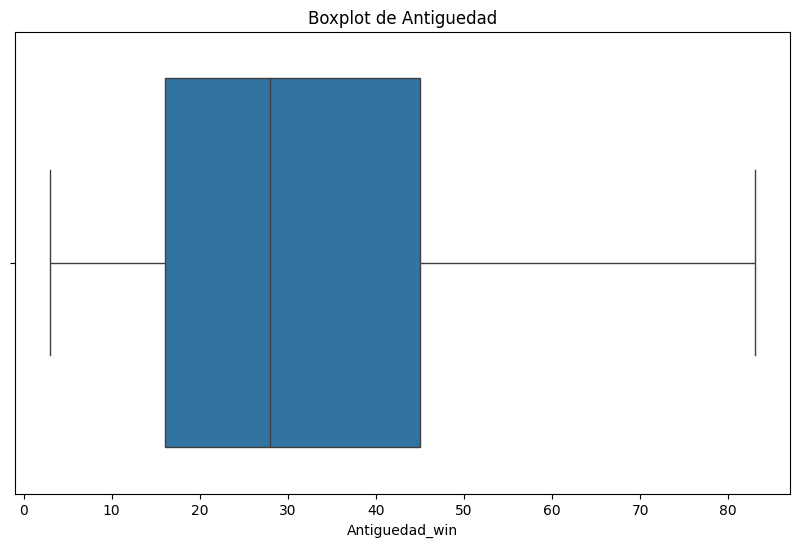

In [193]:
#Comprobar cambios
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Antiguedad_win'])
plt.title('Boxplot de Antiguedad')
plt.show()

In [194]:
# Agrupar en rangos
df_sample['Antiguedad_bin'] = pd.qcut(df_sample['Antiguedad_win'].astype(float), q=10)  # Convert 'Antiguedad_win' to float before applying qcut
df_altitud = df_sample.groupby('Antiguedad_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

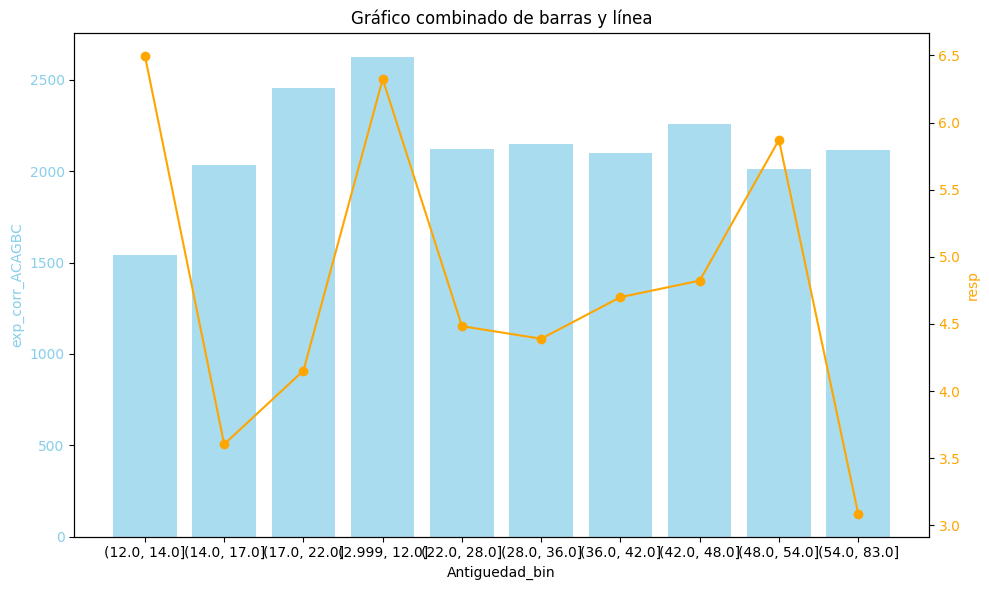

In [195]:
df_sample['Antiguedad_bin']=df_sample['Antiguedad_bin'].astype(str)
df_resumido = df_sample.groupby('Antiguedad_bin').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'Antiguedad_bin',peso,'resp')

#### SUPERFICIE

In [196]:
min_value = df['SUPERFICIE'].min().compute()
max_value = df['SUPERFICIE'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: 0.0
Valor máximo: 9721166.0


In [197]:
#Reemplazamos los datos 0 con la mediana
median_value = df_sample['SUPERFICIE'][df_sample['SUPERFICIE'] > 0].median()
df_sample['SUPERFICIE'] = df_sample['SUPERFICIE'].replace(0, median_value)

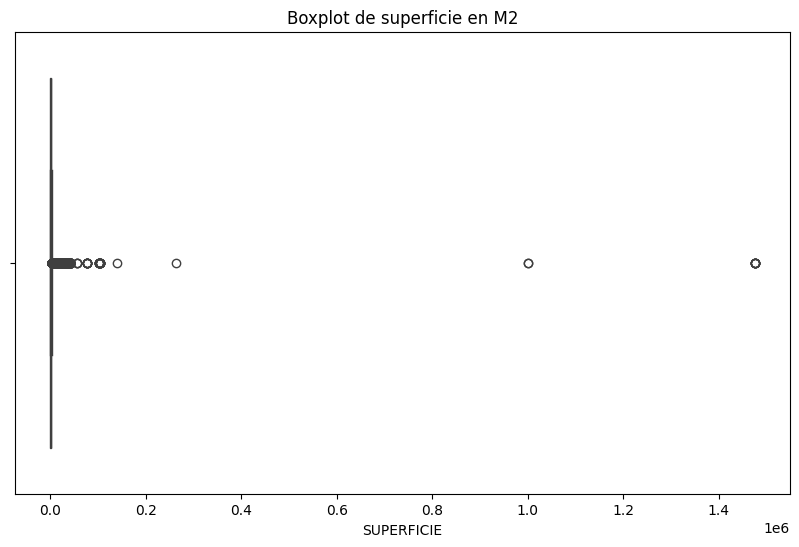

In [198]:
# Crear un boxplot para visualizar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['SUPERFICIE'])
plt.title('Boxplot de superficie en M2')
plt.show()

In [199]:
# Aplicar winsorización
df_sample['Superficie_win'] = mstats.winsorize(df_sample['SUPERFICIE'], limits=[0.01, 0.01])
print(df_sample[['SUPERFICIE', 'Superficie_win']].head())

   SUPERFICIE  Superficie_win
0      3520.0          3520.0
1      3520.0          3520.0
2      3520.0          3520.0
3      3520.0          3520.0
8      4550.0          4550.0


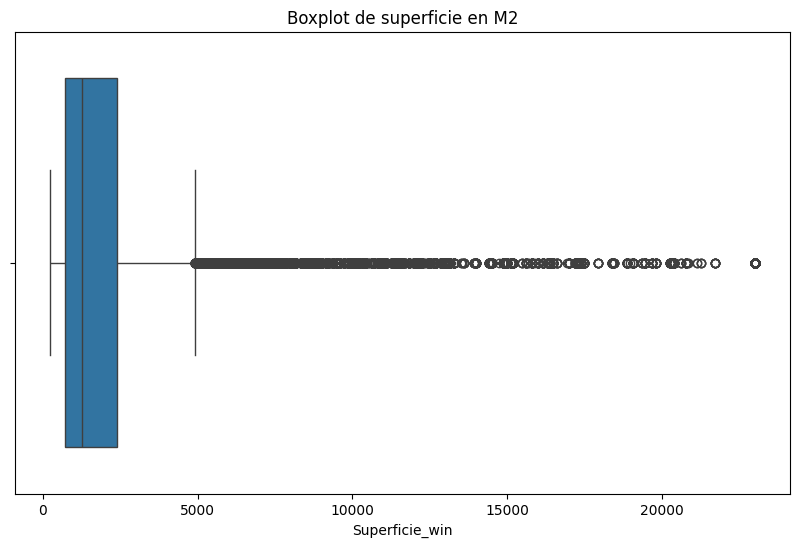

In [200]:
# Boxplot para visualizar cambios
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Superficie_win'])
plt.title('Boxplot de superficie en M2')
plt.show()

In [201]:
# Aplicar la transformación logarítmica
df_sample['SUPERFICIE_log'] = np.log1p(df_sample['Superficie_win'])
print(df_sample[['Superficie_win', 'SUPERFICIE_log']].head())

   Superficie_win  SUPERFICIE_log
0          3520.0        8.166500
1          3520.0        8.166500
2          3520.0        8.166500
3          3520.0        8.166500
8          4550.0        8.423102


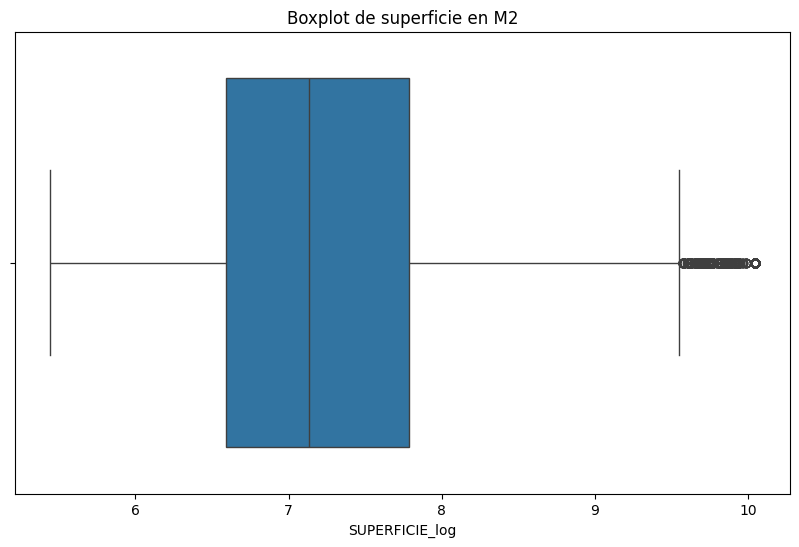

In [202]:
# Boxplot para visualizar cambios
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['SUPERFICIE_log'])
plt.title('Boxplot de superficie en M2')
plt.show()

In [203]:
# Agrupar en rangos
df_sample['SUPERFICIE_bin'] = pd.qcut(df_sample['SUPERFICIE_log'].astype(float), q=10)
df_altitud = df_sample.groupby('SUPERFICIE_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

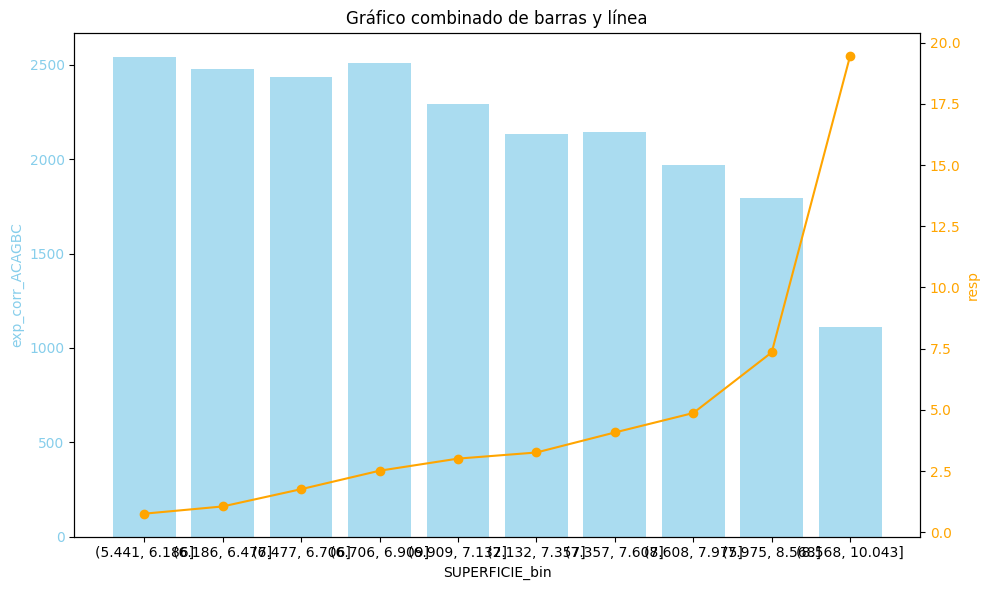

In [204]:
df_sample['SUPERFICIE_bin']=df_sample['SUPERFICIE_bin'].astype(str)
df_resumido = df_sample.groupby('SUPERFICIE_bin').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'SUPERFICIE_bin',peso,'resp')

#### TEMP_MIN_10Y

In [205]:
min_value = df['TEMP_MIN_10Y'].min().compute()
max_value = df['TEMP_MIN_10Y'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: -9999.0
Valor máximo: 6.048653978179667


In [206]:
count_outliers = (df_sample['TEMP_MIN_10Y'] == -9999.0).sum()
count_outliers

np.int64(4837)

In [207]:
#Reemplazamos los datos -9999.0 con la mediana
median_value = df_sample['TEMP_MIN_10Y'][df_sample['TEMP_MIN_10Y'] > -9999.0].median()
df_sample['TEMP_MIN_10Y'] = df_sample['TEMP_MIN_10Y'].replace( -9999.0, median_value)


In [208]:
count_outliers = (df_sample['TEMP_MIN_10Y'] == -9999.0).sum()
count_outliers

np.int64(0)

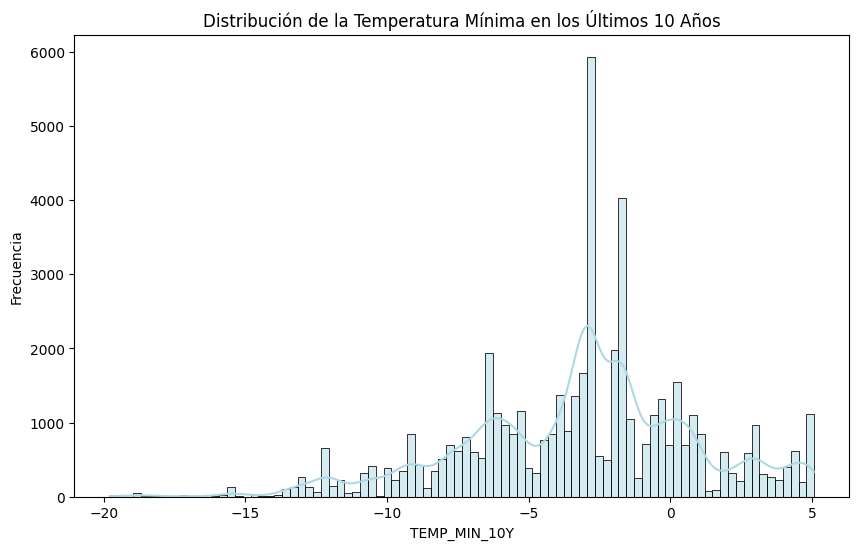

In [209]:
#Histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['TEMP_MIN_10Y'], kde=True, color='lightblue')
plt.title('Distribución de la Temperatura Mínima en los Últimos 10 Años')
plt.xlabel('TEMP_MIN_10Y')
plt.ylabel('Frecuencia')
plt.show()


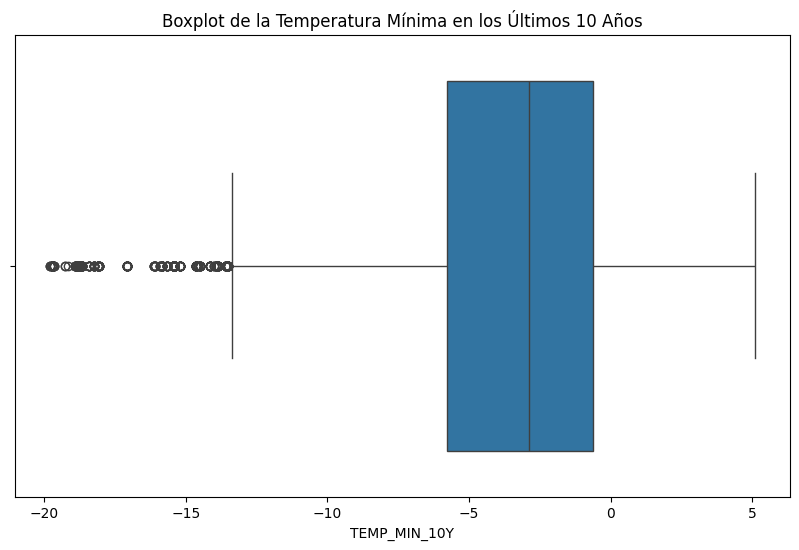

In [210]:
#Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['TEMP_MIN_10Y'])
plt.title('Boxplot de la Temperatura Mínima en los Últimos 10 Años')
plt.show()

In [211]:
# Agrupar en rangos
df_sample['TEMP_MIN_10Y_bin'] = pd.qcut(df_sample['TEMP_MIN_10Y'].astype(float), q=10)
df_altitud = df_sample.groupby('TEMP_MIN_10Y_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

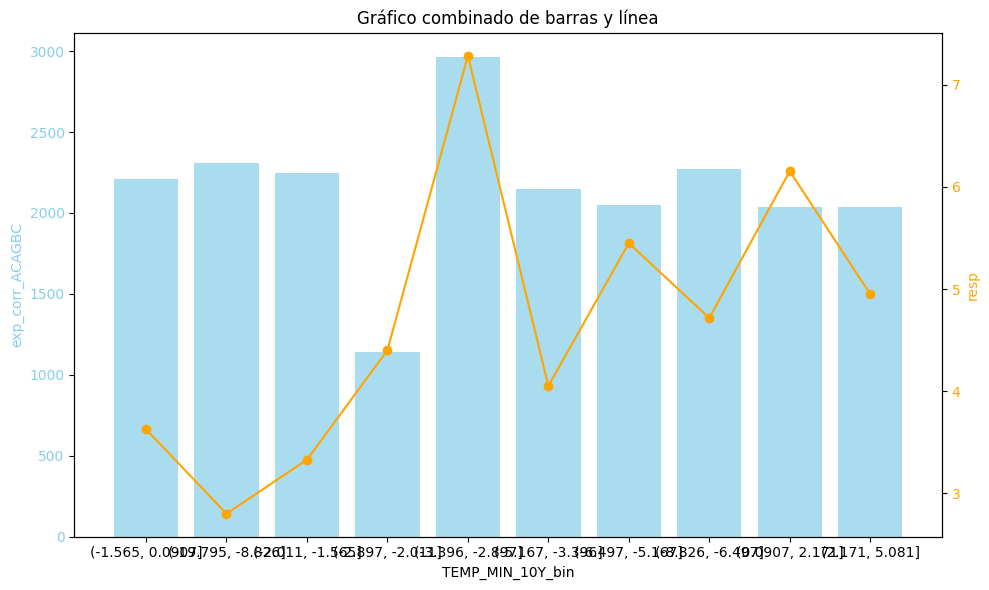

In [212]:
df_sample['TEMP_MIN_10Y_bin']=df_sample['TEMP_MIN_10Y_bin'].astype(str)
df_resumido = df_sample.groupby('TEMP_MIN_10Y_bin').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'TEMP_MIN_10Y_bin',peso,'resp')

#### p_viviendas_mal_estado

In [217]:
min_value = df['p_viviendas_mal_estado'].min().compute()
max_value = df['p_viviendas_mal_estado'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: 0.0
Valor máximo: 0.2773109243697479


In [218]:
# Contar cuántos valores faltantes  hay
missing_values = df_sample['p_viviendas_mal_estado'].isnull().sum()
missing_values

np.int64(0)

In [219]:
# Reemplazar valores faltantes con la mediana
mediana = df_sample['p_viviendas_mal_estado'].median()
df_sample['p_viviendas_mal_estado'].fillna(mediana, inplace=True)

In [220]:
missing_values = df_sample['p_viviendas_mal_estado'].isnull().sum()
missing_values

np.int64(0)

In [221]:
print(df_sample['p_viviendas_mal_estado'].describe())

count    51319.000000
mean         0.024377
std          0.025819
min          0.000000
25%          0.007398
50%          0.015525
75%          0.030178
max          0.209639
Name: p_viviendas_mal_estado, dtype: float64


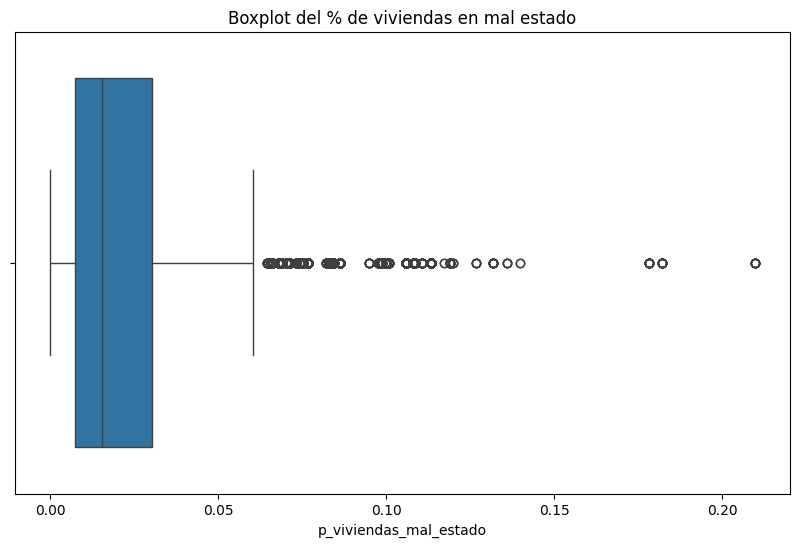

In [222]:
#Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['p_viviendas_mal_estado'])
plt.title('Boxplot del % de viviendas en mal estado')
plt.show()

In [223]:
# Aplicar winsorización
df_sample['p_viviendas_mal_estado_win'] = mstats.winsorize(df_sample['p_viviendas_mal_estado'], limits=[0.01, 0.01])
print(df_sample[['p_viviendas_mal_estado', 'p_viviendas_mal_estado_win']].head())

   p_viviendas_mal_estado  p_viviendas_mal_estado_win
0                0.026968                    0.026968
1                0.026968                    0.026968
2                0.026968                    0.026968
3                0.026968                    0.026968
8                0.026968                    0.026968


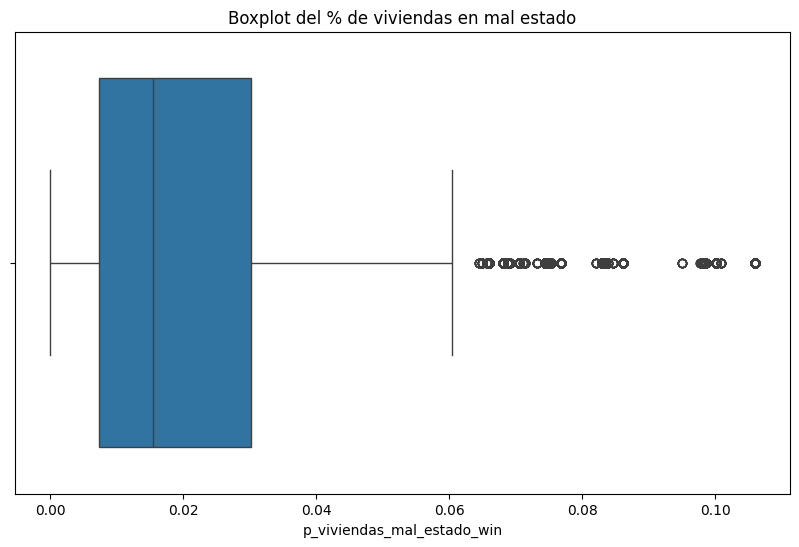

In [224]:
#Boxplot para comprobar
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['p_viviendas_mal_estado_win'])
plt.title('Boxplot del % de viviendas en mal estado')
plt.show()

In [225]:
# Aplicar la transformación logarítmica
df_sample['p_viviendas_mal_estad_log'] = np.log1p(df_sample['p_viviendas_mal_estado_win'])
print(df_sample[['p_viviendas_mal_estado_win', 'p_viviendas_mal_estad_log']].head())

   p_viviendas_mal_estado_win  p_viviendas_mal_estad_log
0                    0.026968                   0.026611
1                    0.026968                   0.026611
2                    0.026968                   0.026611
3                    0.026968                   0.026611
8                    0.026968                   0.026611


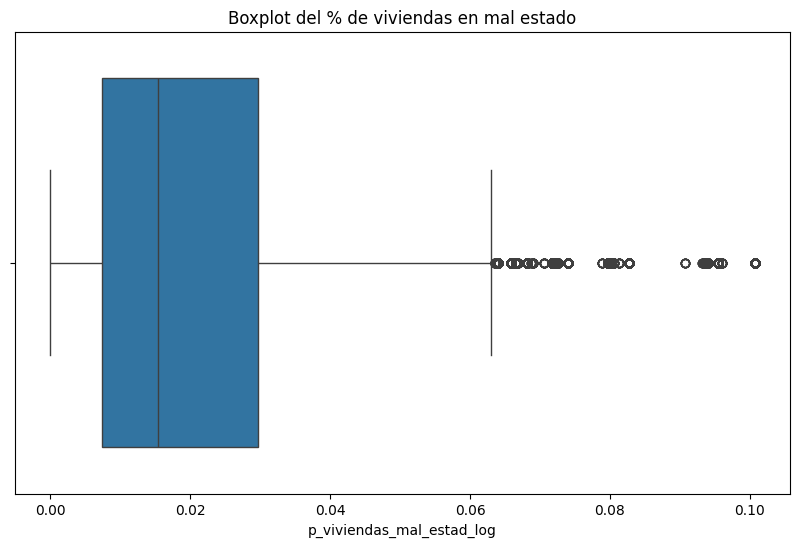

In [226]:
#Boxplot para comprobar
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['p_viviendas_mal_estad_log'])
plt.title('Boxplot del % de viviendas en mal estado')
plt.show()

In [227]:
# Agrupar en rangos
df_sample['p_viviendas_mal_bin'] = pd.qcut(df_sample['p_viviendas_mal_estad_log'].astype(float), q=10)
df_altitud = df_sample.groupby('p_viviendas_mal_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

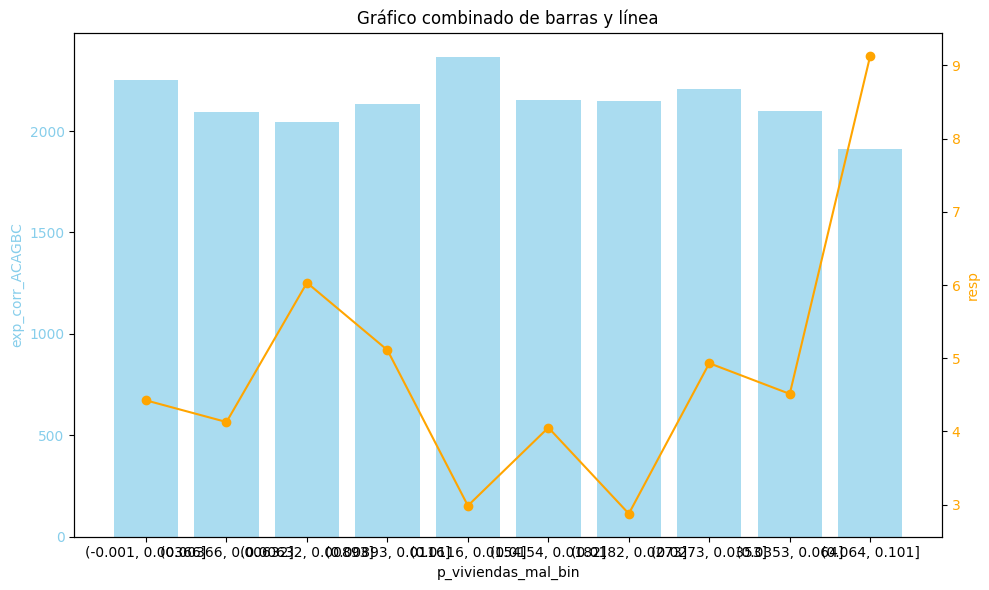

In [228]:
df_sample['p_viviendas_mal_bin']=df_sample['p_viviendas_mal_bin'].astype(str)
df_resumido = df_sample.groupby('p_viviendas_mal_bin').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'p_viviendas_mal_bin',peso,'resp')

#### precipitacion_invier

In [229]:
min_value = df['precipitacion_invier'].min().compute()
max_value = df['precipitacion_invier'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: 0.16088761915205177
Valor máximo: 8.66747690613921


In [230]:
# Contar cuántos valores faltantes  hay
missing_values = df_sample['precipitacion_invier'].isnull().sum()
missing_values

np.int64(121)

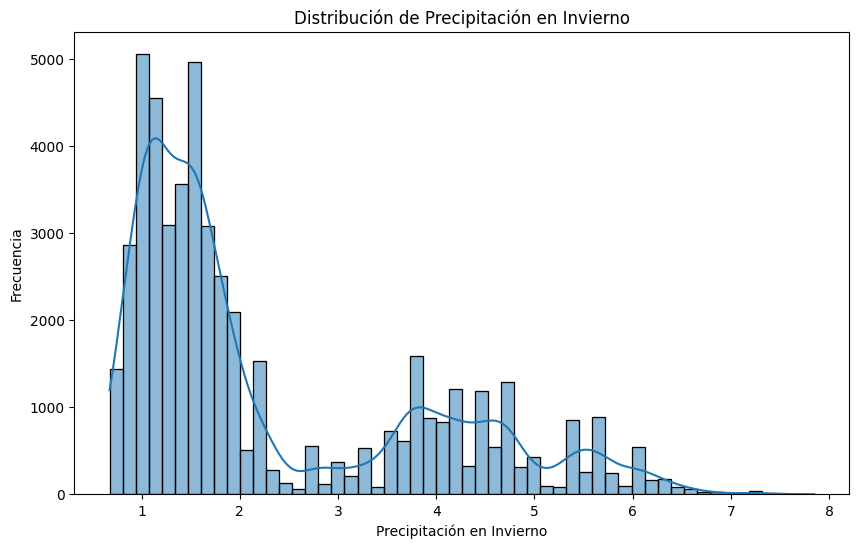

In [231]:
# Graficar histograma
plt.figure(figsize=(10,6))
sns.histplot(df_sample['precipitacion_invier'], kde=True)
plt.title('Distribución de Precipitación en Invierno')
plt.xlabel('Precipitación en Invierno')
plt.ylabel('Frecuencia')
plt.show()

In [232]:
# Calcular la mediana
mediana_precipitacion = df_sample['precipitacion_invier'].median()
# Reemplazar los valores faltantes con la mediana
df_sample['precipitacion_invier'].fillna(mediana_precipitacion, inplace=True)

In [233]:
df_sample['precipitacion_invier'].isnull().sum()

np.int64(0)

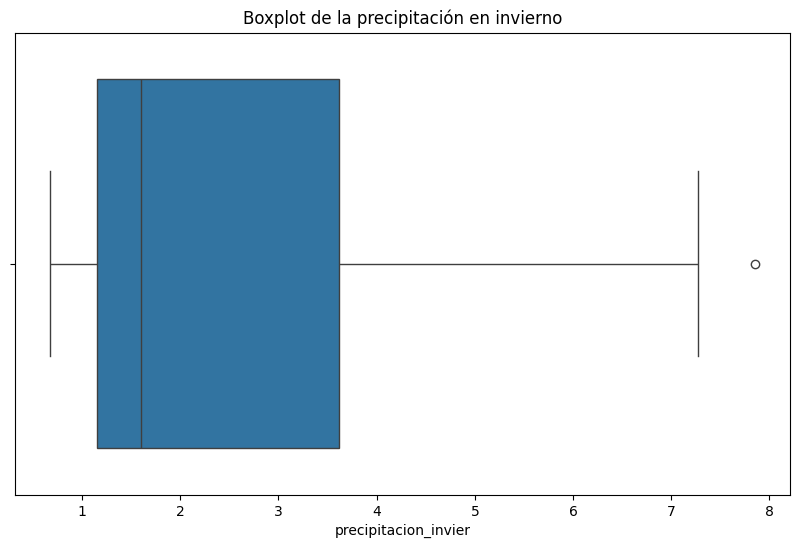

In [234]:
#Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['precipitacion_invier'])
plt.title('Boxplot de la precipitación en invierno')
plt.show()

In [235]:
# Agrupar en rangos
df_sample['precipitacion_invier_bin'] = pd.qcut(df_sample['precipitacion_invier'].astype(float), q=10)
df_altitud = df_sample.groupby('precipitacion_invier_bin').agg({
    'resp': 'mean',
    peso: 'sum'
}).reset_index()

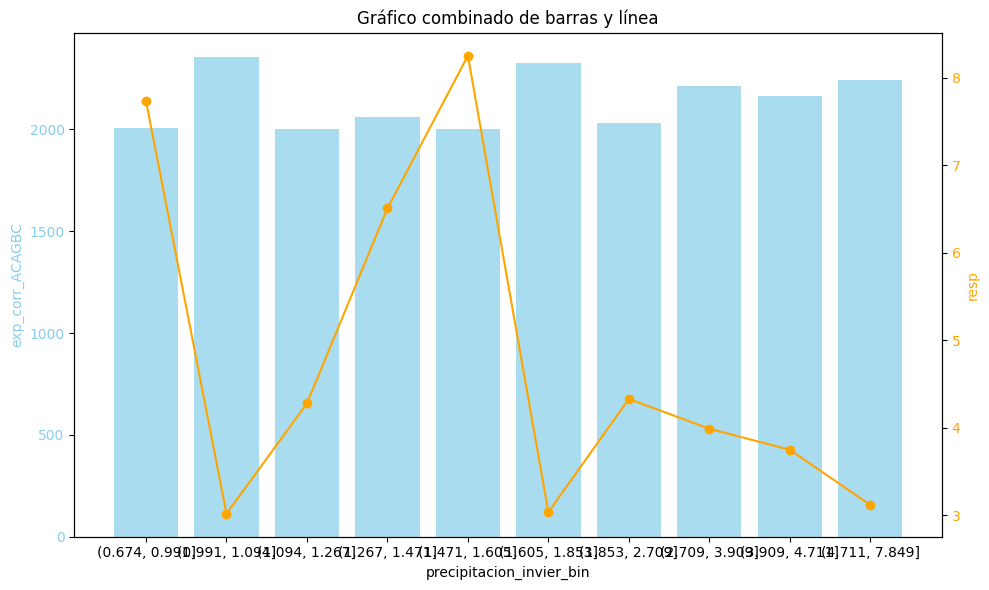

In [236]:
df_sample['precipitacion_invier_bin']=df_sample['precipitacion_invier_bin'].astype(str)
df_resumido = df_sample.groupby('precipitacion_invier_bin').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'precipitacion_invier_bin',peso,'resp')

#### anualidad_seguro

In [237]:
min_value = df['anualidad_seguro'].min().compute()
max_value = df['anualidad_seguro'].max().compute()

print("Valor mínimo:", min_value)
print("Valor máximo:", max_value)

Valor mínimo: 0.0
Valor máximo: 56.0


In [238]:
# Contar cuántos valores faltantes  hay
missing_values = df_sample['anualidad_seguro'].isnull().sum()
missing_values

np.int64(0)

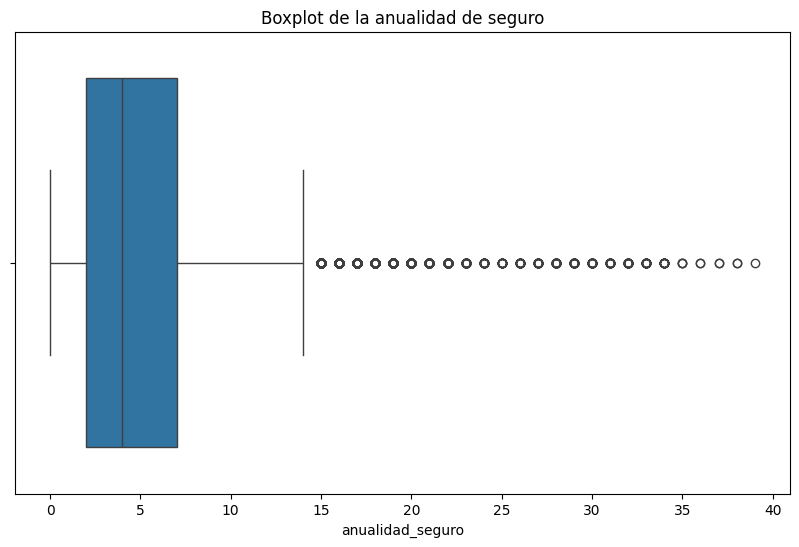

In [239]:
#Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['anualidad_seguro'])
plt.title('Boxplot de la anualidad de seguro')
plt.show()

In [240]:
# Aplicar winsorización
df_sample['anualidad_win'] = mstats.winsorize(df_sample['anualidad_seguro'], limits=[0.01, 0.01])
print(df_sample[['anualidad_seguro', 'anualidad_win']].head())

   anualidad_seguro  anualidad_win
0               4.0            4.0
1               3.0            3.0
2               6.0            6.0
3               7.0            7.0
8               2.0            2.0


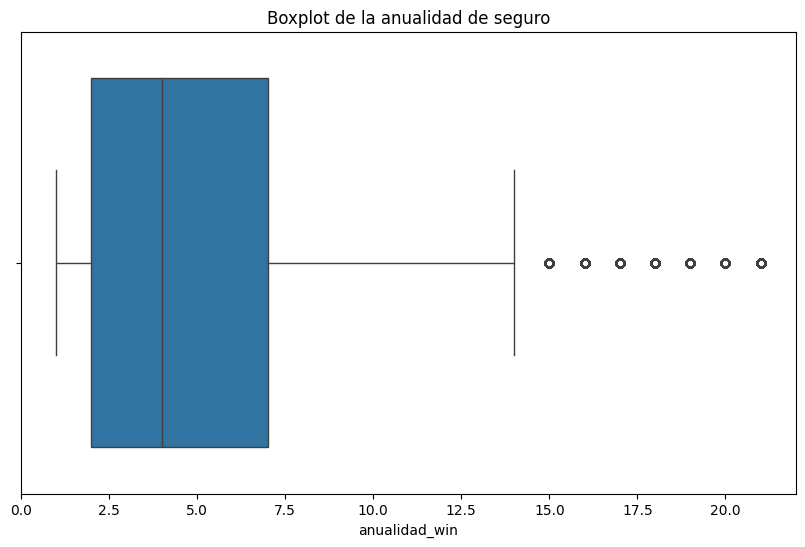

In [241]:
#Boxplot para comprobar
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['anualidad_win'])
plt.title('Boxplot de la anualidad de seguro')
plt.show()

In [242]:
# Aplicar la transformación logarítmica
df_sample['anualidad_log'] = np.log1p(df_sample['anualidad_win'])
print(df_sample[['anualidad_win', 'anualidad_log']].head())

   anualidad_win  anualidad_log
0            4.0       1.609438
1            3.0       1.386294
2            6.0       1.945910
3            7.0       2.079442
8            2.0       1.098612


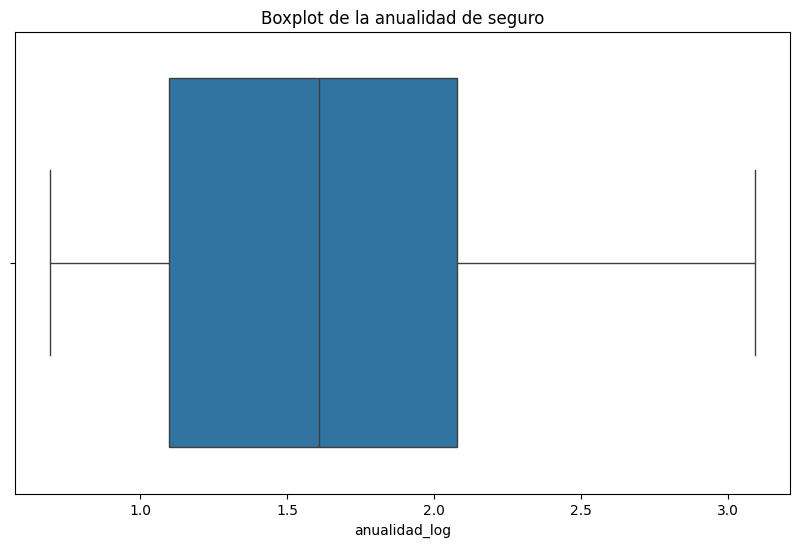

In [243]:
#Boxplot para comprobar
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['anualidad_log'])
plt.title('Boxplot de la anualidad de seguro')
plt.show()

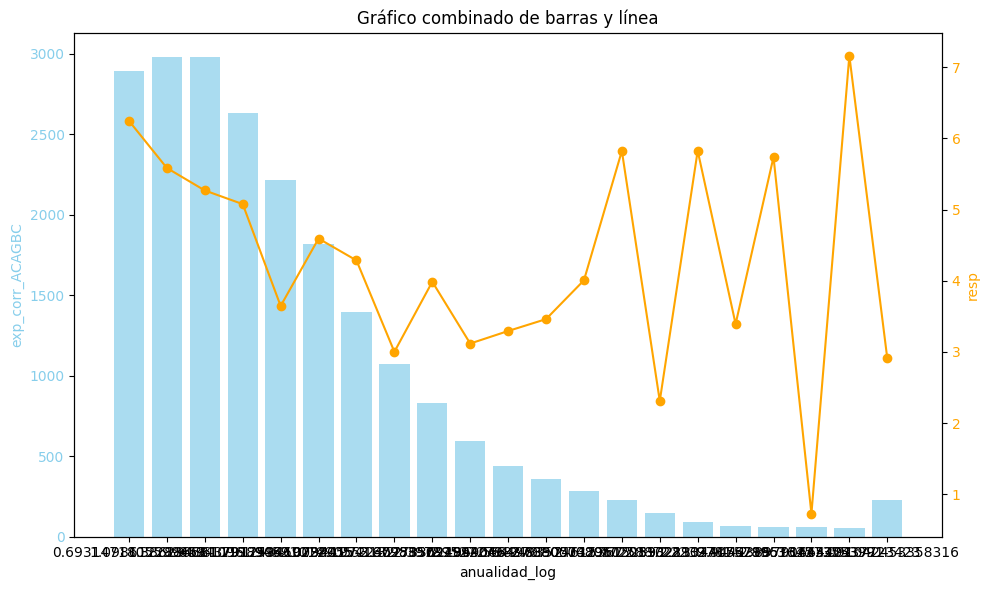

In [244]:
df_sample['anualidad_log']=df_sample['anualidad_log'].astype(str)
df_resumido = df_sample.groupby('anualidad_log').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'anualidad_log',peso,'resp')

####MODELO GLM PARA LA FRECUENCIA

In [245]:
factores=['Altitud_win','Antiguedad_win','anualidad_log','SUPERFICIE_log','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,object
SUPERFICIE_log,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


In [246]:
df_sample['anualidad_log']=df_sample['anualidad_log'].astype(float)

In [247]:
df_sample['anualidad_seguro'].dtypes

dtype('float64')

In [248]:
factores=['Altitud_win','Antiguedad_win','anualidad_log','SUPERFICIE_log','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,float64
SUPERFICIE_log,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


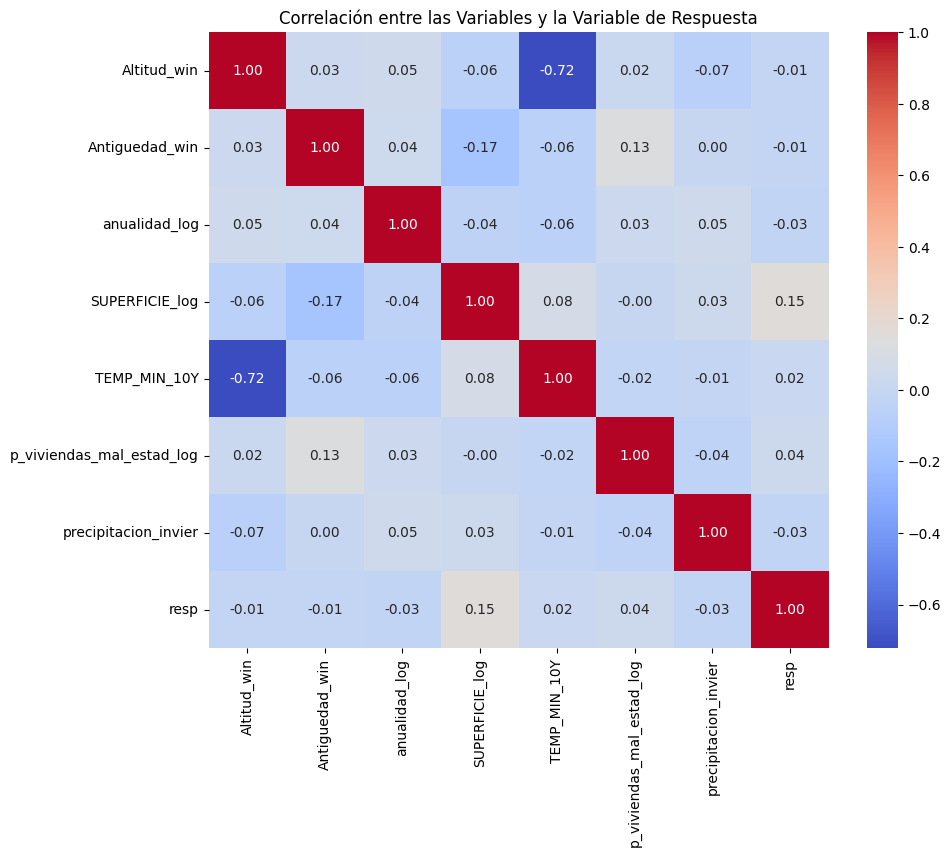

In [249]:
# Calcular la correlación entre las variables
corr_matrix = df_sample[factores + ['resp']].corr()

# Graficar un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre las Variables y la Variable de Respuesta')
plt.show()

In [250]:
list(set(factores))

['Antiguedad_win',
 'anualidad_log',
 'SUPERFICIE_log',
 'Altitud_win',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log',
 'TEMP_MIN_10Y']

#### MODELO 1

In [252]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:                51319
Model:                            GLM   Df Residuals:                    51311
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5230e+06
Date:                Sun, 13 Apr 2025   Deviance:                   3.0074e+06
Time:                        15:41:18   Pearson chi2:                 1.66e+09
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [253]:
#Cálculo de métrica para comparar modelos, penaliza modelos mas complejos (cuando tiene mas variables, buscamos modelos sencillos) Nos quedamos con el modelo que de el BIC más bajo
def calculate_bic(model):
    n = len(model.model.endog)  # Número de observaciones
    k = model.df_model + 1  # Número de parámetros (df_model incluye los coeficientes, sumamos 1 por el intercepto)
    bic = np.log(n) * k - 2 * model.llf  # BIC = ln(n) * k - 2 * log-verosimilitud
    return bic
calculate_bic(resultado)

np.float64(3046171.445053928)

#### MODELO 2


In [254]:
#Eliminando la variable TEMP_MIN_10Y
factores2=['Altitud_win','Antiguedad_win','anualidad_log','SUPERFICIE_log','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores2].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,float64
SUPERFICIE_log,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


In [255]:
list(set(factores2))

['Antiguedad_win',
 'anualidad_log',
 'SUPERFICIE_log',
 'Altitud_win',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log']

In [256]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores2].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo2 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado2 = modelo2.fit()

# Mostrar los resultados del modelo
print(resultado2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:                51319
Model:                            GLM   Df Residuals:                    51312
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5230e+06
Date:                Sun, 13 Apr 2025   Deviance:                   3.0074e+06
Time:                        15:42:07   Pearson chi2:                 1.66e+09
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [292]:
calculate_bic(resultado2)

np.float64(3046161.351070892)

#### MODELO 3

In [258]:
# Eliminado la variable p_viviendas_mal_estad_log
factores3=['Altitud_win','Antiguedad_win','anualidad_log','SUPERFICIE_log','precipitacion_invier']
df_sample[factores3].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,float64
SUPERFICIE_log,float64
precipitacion_invier,float64


In [259]:
list(set(factores3))

['Antiguedad_win',
 'anualidad_log',
 'SUPERFICIE_log',
 'Altitud_win',
 'precipitacion_invier']

In [260]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores3].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo3 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado3 = modelo3.fit()

# Mostrar los resultados del modelo
print(resultado3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:                51319
Model:                            GLM   Df Residuals:                    51313
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5306e+06
Date:                Sun, 13 Apr 2025   Deviance:                   3.0226e+06
Time:                        15:43:11   Pearson chi2:                 1.63e+09
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.4251 

In [291]:
calculate_bic(resultado3)

np.float64(156869.987637083)

####MODELO GLM PARA LA SEVERIDAD

In [262]:
#Definimos las variables de respuesta y peso
var_resp2='CUPD_CAP_Corr_aguaacagbc'
peso2='stro_Corr_AGUAACAGBC'
ano='year'

In [271]:
factores4=['Altitud_win','Antiguedad_win','anualidad_log','SUPERFICIE_log','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores4].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,float64
SUPERFICIE_log,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


#### MODELO 1 SEVERIDAD

In [264]:
list(set(factores4))

['Antiguedad_win',
 'anualidad_log',
 'SUPERFICIE_log',
 'Altitud_win',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log',
 'TEMP_MIN_10Y']

In [265]:
df_sample['resp2']=df_sample[var_resp2]/df_sample[peso2]

In [284]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores4].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp2']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso2])

# Crear el modelo GLM con enlace logarítmico y familia Gamma
modelo4 = sm.GLM(y, X, family=sm.families.Gamma(), offset=offset)

# Ajustar el modelo
resultado4 = modelo4.fit()

# Mostrar los resultados del modelo
print(resultado4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  resp2   No. Observations:                10919
Model:                            GLM   Df Residuals:                    10911
Model Family:                   Gamma   Df Model:                            7
Link Function:           InversePower   Scale:                          1.4669
Method:                          IRLS   Log-Likelihood:                -78398.
Date:                Sun, 13 Apr 2025   Deviance:                       14256.
Time:                        15:52:28   Pearson chi2:                 1.60e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01419
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [290]:
calculate_bic(resultado4)

np.float64(156869.987637083)

#### MODELO 2 SEVERIDAD

In [286]:
factores5=['Altitud_win','Antiguedad_win','anualidad_log','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores5].dtypes

,0
Altitud_win,float64
Antiguedad_win,float64
anualidad_log,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


In [287]:
list(set(factores5))

['Antiguedad_win',
 'anualidad_log',
 'Altitud_win',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log',
 'TEMP_MIN_10Y']

In [288]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores5].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp2']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso2])

# Crear el modelo GLM con enlace logarítmico y familia Gamma
modelo5 = sm.GLM(y, X, family=sm.families.Gamma(), offset=offset)

# Ajustar el modelo
resultado5 = modelo5.fit()

# Mostrar los resultados del modelo
print(resultado5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  resp2   No. Observations:                10919
Model:                            GLM   Df Residuals:                    10912
Model Family:                   Gamma   Df Model:                            6
Link Function:           InversePower   Scale:                          1.4671
Method:                          IRLS   Log-Likelihood:                -78398.
Date:                Sun, 13 Apr 2025   Deviance:                       14256.
Time:                        15:52:47   Pearson chi2:                 1.60e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01416
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [289]:
calculate_bic(resultado5)

np.float64(156861.50515191554)

#### MODELO 3 SEVERIDAD

In [293]:
#Eliminando Altitud_win
factores6=['Antiguedad_win','anualidad_log','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores6].dtypes

,0
Antiguedad_win,float64
anualidad_log,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


In [294]:
list(set(factores6))

['Antiguedad_win',
 'anualidad_log',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log',
 'TEMP_MIN_10Y']

In [295]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores6].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp2']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso2])

# Crear el modelo GLM con enlace logarítmico y familia Gamma
modelo6 = sm.GLM(y, X, family=sm.families.Gamma(), offset=offset)

# Ajustar el modelo
resultado6 = modelo6.fit()

# Mostrar los resultados del modelo
print(resultado6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  resp2   No. Observations:                10919
Model:                            GLM   Df Residuals:                    10913
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                          1.4674
Method:                          IRLS   Log-Likelihood:                -78399.
Date:                Sun, 13 Apr 2025   Deviance:                       14257.
Time:                        15:55:35   Pearson chi2:                 1.60e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01411
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [296]:
calculate_bic(resultado6)

np.float64(156853.43893092894)

#### MODELO 4 SEVERIDAD

In [297]:
#Eliminando anualidad_log
factores7=['Antiguedad_win','TEMP_MIN_10Y','p_viviendas_mal_estad_log','precipitacion_invier']
df_sample[factores7].dtypes

,0
Antiguedad_win,float64
TEMP_MIN_10Y,float64
p_viviendas_mal_estad_log,float64
precipitacion_invier,float64


In [298]:
list(set(factores7))

['Antiguedad_win',
 'precipitacion_invier',
 'p_viviendas_mal_estad_log',
 'TEMP_MIN_10Y']

In [299]:
# Seleccionar las variables predictoras (sin necesidad de crear variables dummy)
X = df_sample[factores7].astype('float')  # Factores ya son numéricos, así que simplemente los convertimos a float
X = sm.add_constant(X)  # Agregar una constante (intercepto) al modelo

# Variable de respuesta
y = df_sample['resp2']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_sample[peso2])

# Crear el modelo GLM con enlace logarítmico y familia Gamma
modelo7 = sm.GLM(y, X, family=sm.families.Gamma(), offset=offset)

# Ajustar el modelo
resultado7 = modelo7.fit()

# Mostrar los resultados del modelo
print(resultado7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  resp2   No. Observations:                10919
Model:                            GLM   Df Residuals:                    10914
Model Family:                   Gamma   Df Model:                            4
Link Function:           InversePower   Scale:                          1.4668
Method:                          IRLS   Log-Likelihood:                -78399.
Date:                Sun, 13 Apr 2025   Deviance:                       14260.
Time:                        15:57:36   Pearson chi2:                 1.60e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01390
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [300]:
calculate_bic(resultado7)

np.float64(156845.20043107783)